In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd "/content/drive/MyDrive/AML_Assignment_2_2021"

/content/drive/MyDrive/AML_Assignment_2_2021


In [1]:
ls

AML_Assignment_2_GridSearch.ipynb   ex3_convnet_gridsearch_results_complete.csv
AML_Assignment_2_script.ipynb       ex3_convnet_gridsearch_results_part_2.csv
Data_Augmentation_Tests.ipynb       ex3_convnet_gridsearch_results_part_3.csv
__pycache__/                        ex3_convnet_utils.py
best_model.bin                      ex3_data_augmentation_complete.csv
datasets/                           post_training_filters/
early_stopped_model.bin             pre_training_filters/
ex3_convnet_gridsearch.py           train_valid_history_plots/
ex3_convnet_gridsearch_results.csv  valid_accuracy_history_plots/


Using device: cuda
ConvNet(
  (layers): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
    (4): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

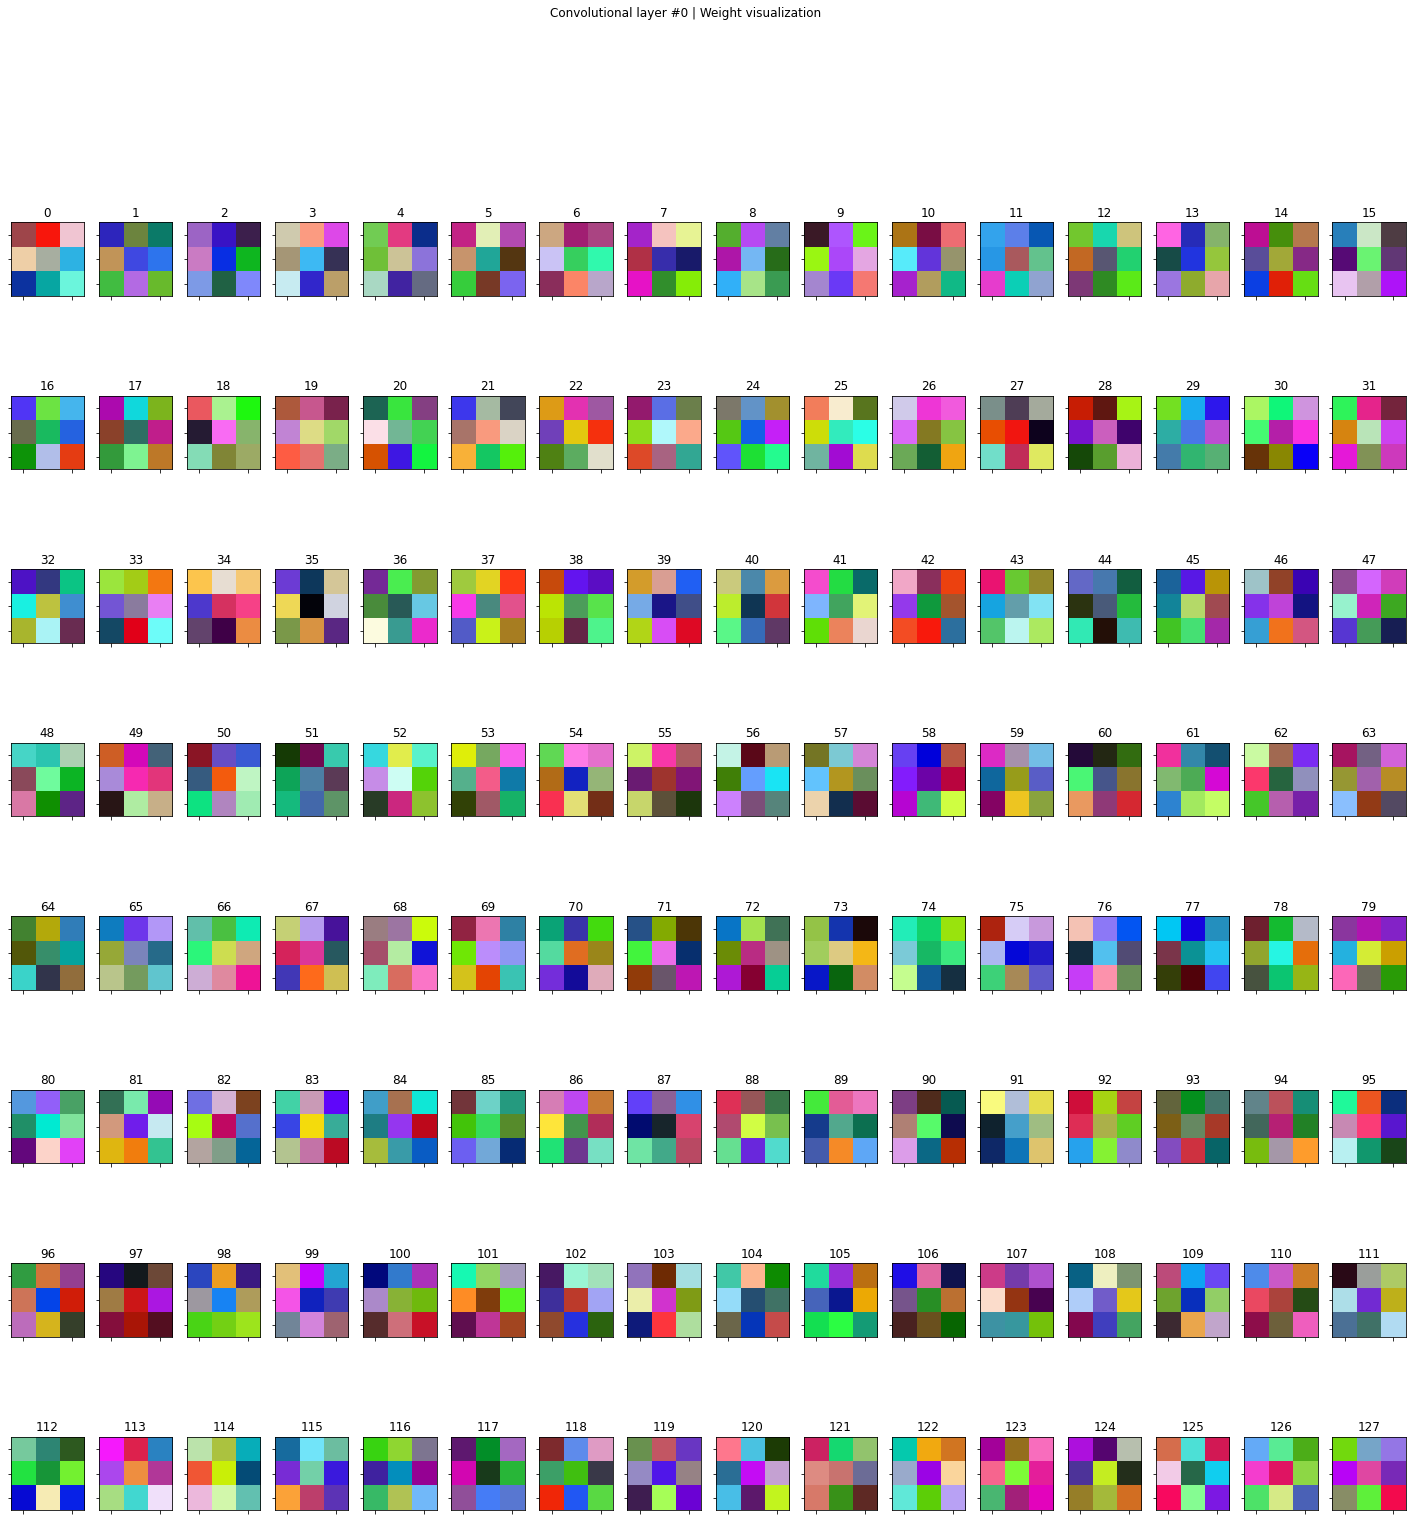

Epoch [1/30], Step [100/245], Loss: 2.0030
Epoch [1/30], Step [200/245], Loss: 1.8833
Validation accuracy is: 38.4 %
Best model saved. Best accuracy:  38.4
Epoch [2/30], Step [100/245], Loss: 1.8215
Epoch [2/30], Step [200/245], Loss: 1.8770
Validation accuracy is: 35.3 %
Epoch [3/30], Step [100/245], Loss: 1.7871
Epoch [3/30], Step [200/245], Loss: 1.7764
Validation accuracy is: 41.0 %
Best model saved. Best accuracy:  41.0
Epoch [4/30], Step [100/245], Loss: 1.7177
Epoch [4/30], Step [200/245], Loss: 1.6825
Validation accuracy is: 40.8 %
Epoch [5/30], Step [100/245], Loss: 1.6404
Epoch [5/30], Step [200/245], Loss: 1.7209
Validation accuracy is: 56.7 %
Best model saved. Best accuracy:  56.7
Epoch [6/30], Step [100/245], Loss: 1.6267
Epoch [6/30], Step [200/245], Loss: 1.5611
Validation accuracy is: 47.8 %
Epoch [7/30], Step [100/245], Loss: 1.5840
Epoch [7/30], Step [200/245], Loss: 1.5985
Validation accuracy is: 59.5 %
Best model saved. Best accuracy:  59.5
Epoch [8/30], Step [100/2

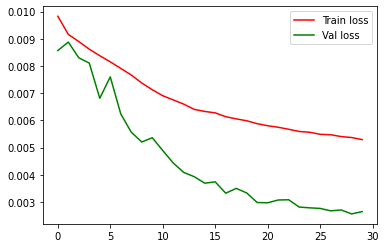

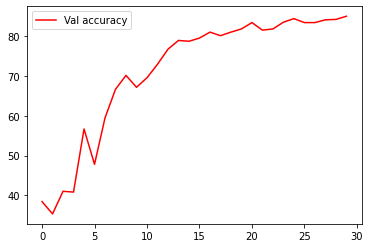

Start testing phase for the best model
End of testing for the best model
Accuracy of the network on the 1000 test images: 87.0 %


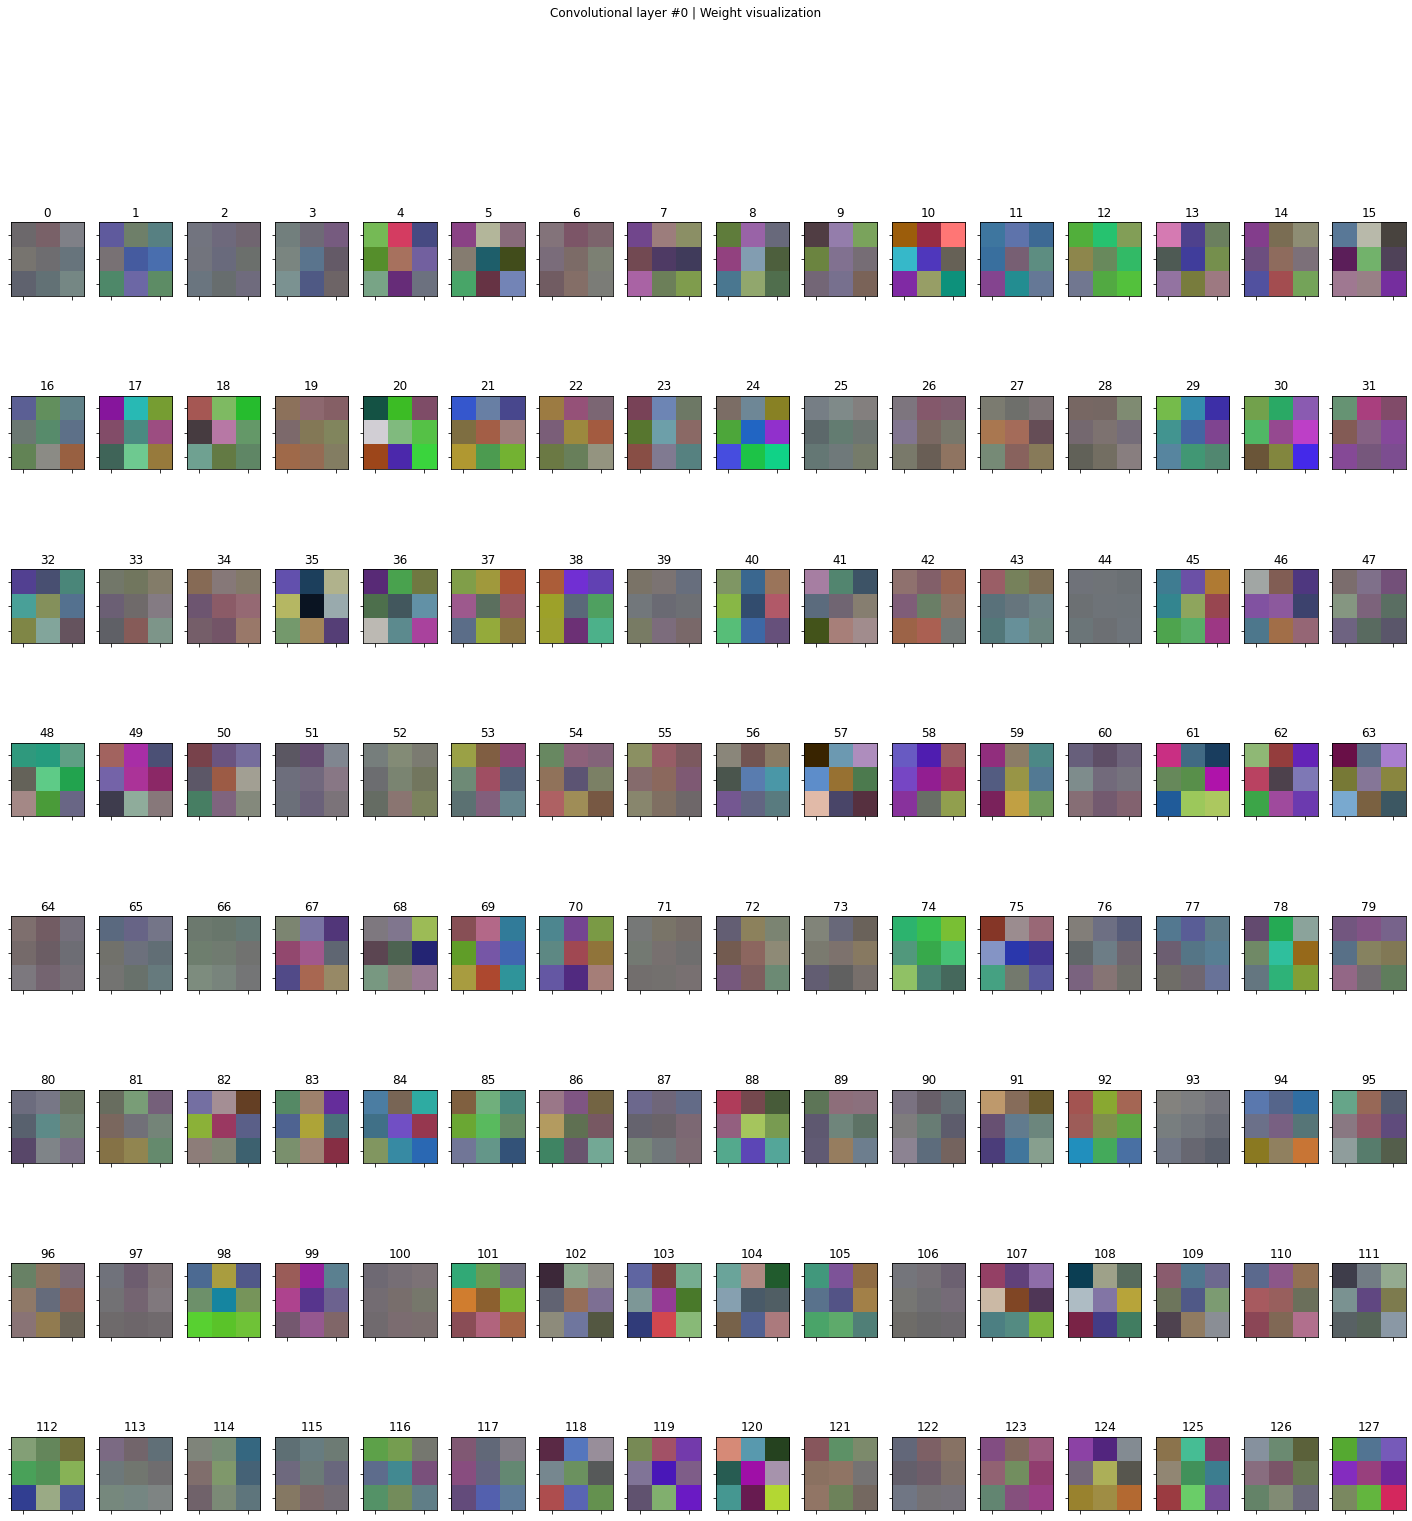

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

import matplotlib.pyplot as plt


def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr



#--------------------------------
# Device configuration
#--------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

#--------------------------------
# Hyper-parameters
#--------------------------------

input_size = 3
num_classes = 10
hidden_size = [128, 512, 512, 512, 512]
num_training = 49000
num_validation = 1000
norm_layer = 'BN'

num_epochs = 30
batch_size = 200
learning_rate = 0.001
learning_rate_decay = 0.9
reg = 0.005



#-------------------------------------------------
# Load the CIFAR-10 dataset
#-------------------------------------------------
#################################################################################
# TODO: Q3.a Choose the right data augmentation transforms with the right       #
# hyper-parameters and put them in the data_aug_transforms variable             #
#################################################################################



DEFAULT_EARLY_STOPPED_MODEL_PATH = './early_stopped_model_weights.bin'
DEFAULT_BEST_MODEL_PATH = './best_model_weights.bin'

data_aug_transforms = []
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# These are a few transformations that we tried.

#data_aug_transforms.append(transforms.ColorJitter(brightness=.5, hue=.05, saturation=.05))
#data_aug_transforms.append(transforms.RandomPerspective(distortion_scale=0.6, p=1.0))
#data_aug_transforms.append(transforms.RandomHorizontalFlip(p=0.3))
#data_aug_transforms.append(transforms.RandomRotation(20))
#data_aug_transforms.append(transforms.RandomInvert(p=0.2))

# Best results we got used these two transformations.
data_aug_transforms.append(transforms.RandomHorizontalFlip(p=0.3))
data_aug_transforms.append(transforms.RandomRotation(20))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
norm_transform = transforms.Compose(data_aug_transforms+[transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                     ])
cifar_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                           train=True,
                                           transform=norm_transform,
                                           download=False)

test_dataset = torchvision.datasets.CIFAR10(root='datasets/',
                                          train=False,
                                          transform=test_transform
                                          )

#-------------------------------------------------
# Prepare the training and validation splits
#-------------------------------------------------
mask = list(range(num_training))
train_dataset = torch.utils.data.Subset(cifar_dataset, mask)
mask = list(range(num_training, num_training + num_validation))
val_dataset = torch.utils.data.Subset(cifar_dataset, mask)

#-------------------------------------------------
# Data loader
#-------------------------------------------------
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


#-------------------------------------------------
# Convolutional neural network (Q1.a and Q2.a)
# Set norm_layer for different networks whether using batch normalization
#-------------------------------------------------
class ConvNet(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, norm_layer=None):
        super(ConvNet, self).__init__()
        #################################################################################
        # TODO: Initialize the modules required to implement the convolutional layer    #
        # described in the exercise.                                                    #
        # For Q1.a make use of conv2d and relu layers from the torch.nn module.         #
        # For Q2.a make use of BatchNorm2d layer from the torch.nn module.              #
        # For Q3.b Use Dropout layer from the torch.nn module.                          #
        #################################################################################
        layers = []
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        #print("Hidden layers: ", hidden_layers)
        
        layers.append(nn.Conv2d(3, hidden_layers[0], kernel_size = 3, padding = 1, stride = 1))
        
        if norm_layer: # Batch normalization
            layers.append(nn.BatchNorm2d(hidden_layers[0]))
            
        
        layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
        layers.append(nn.ReLU())
                
        for i in range(1, len(hidden_layers)): # The -1 since the last layer is Linear
            
            layers.append(nn.Conv2d(hidden_layers[i-1], hidden_layers[i], kernel_size = 3, padding = 1, stride = 1))
            
            if norm_layer:
                layers.append(nn.BatchNorm2d(hidden_layers[i]))
            
            layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
            layers.append(nn.ReLU(inplace = False))
                    
        
        layers.append(nn.Flatten())
        layers.append(nn.Linear(hidden_layers[-1], num_classes))
        
        
        layers.append(nn.Dropout(p = 0.5))  # the value of "p" should be between 0.1 and 0.9
        
        
        self.layers = nn.Sequential(*layers)
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        #################################################################################
        # TODO: Implement the forward pass computations                                 #
        #################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        out = self.layers(x)
        
        '''
        # THIS IS JUST FOR DEBUGGING the ouput dims of each layer - hence the assert 1==0 to force a stop, 
        out = x
        
        
        for i in range(0, len(self.layers)):
            out = self.layers[i](out)
            print("i: ", i, " | Layers: ", self.layers[i], " | Out shape: ", out.shape)
        
        
        assert 1 == 0, "STOP HERE"
        '''
    
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out



#-------------------------------------------------
# Calculate the model size (Q1.b)
# if disp is true, print the model parameters, otherwise, only return the number of parameters.
#-------------------------------------------------
def PrintModelSize(model, disp=True):
    #################################################################################
    # TODO: Implement the function to count the number of trainable parameters in   #
    # the input model. This useful to track the capacity of the model you are       #
    # training                                                                      #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    model_sz = np.nan
    
    model_sz = np.sum([p.numel() for p in model.parameters() if p.requires_grad])
    
    if disp:
        print("Model size | Number of parameters: ", model_sz)

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return model_sz



#-------------------------------------------------
# Calculate the model size (Q1.c)
# visualize the convolution filters of the first convolution layer of the input model
#-------------------------------------------------
def VisualizeFilter(model):
    #################################################################################
    # TODO: Implement the functiont to visualize the weights in the first conv layer#
    # in the model. Visualize them as a single image of stacked filters.            #
    # You can use matlplotlib.imshow to visualize an image in python                #
    #################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    layer_0 = model.layers[0]
    
    
    weights = np.array(torch.Tensor.cpu(layer_0.weight).detach().numpy(), np.float32)
    
    num_rows = 8
    num_cols = 16
    
    
    fig, ax = plt.subplots(nrows = num_rows, ncols = num_cols, figsize = (25, 25))
    fig.suptitle("Convolutional layer #0 | Weight visualization")

    weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights)) # Normalize into [0, 1]
    
    index_weight = 0
    
    for i in range(num_rows):
        for j in range(num_cols):
            
            weights_ij = weights[index_weight]
                        
            ax[i, j].title.set_text(index_weight)
            ax[i, j].imshow(weights_ij, vmin = 0, vmax = 1)
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
            
            index_weight += 1    
        
    plt.show()
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****



#======================================================================================
# Q1.a: Implementing convolutional neural net in PyTorch
#======================================================================================
# In this question we will implement a convolutional neural networks using the PyTorch
# library.  Please complete the code for the ConvNet class evaluating the model
#--------------------------------------------------------------------------------------
model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer).to(device)
# Q2.a - Initialize the model with correct batch norm layer

model.apply(weights_init)
# Print the model
print(model)
# Print model size
#======================================================================================
# Q1.b: Implementing the function to count the number of trainable parameters in the model
#======================================================================================
PrintModelSize(model)
#======================================================================================
# Q1.a: Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
#======================================================================================
VisualizeFilter(model)



# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=reg)

# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
best_accuracy = None
accuracy_val = []
best_model = type(model)(input_size, hidden_size, num_classes, norm_layer=norm_layer) # get a new instance
#best_model = ConvNet(input_size, hidden_size, num_classes, norm_layer=norm_layer)
for epoch in range(num_epochs):

    model.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_iter += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_train.append(loss_iter/(len(train_loader)*batch_size))

    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
        
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        print('Validation accuracy is: {} %'.format(accuracy))
        
        #################################################################################
        # TODO: Q2.b Implement the early stopping mechanism to save the model which has #
        # the model with the best validation accuracy so-far (use best_model).          #
        #################################################################################

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        epsilon = 1e-4 # Difference which is allowed
        
        
        DEFAULT_PATIENCE = 4

        if num_epochs > 10:
          DEFAULT_PATIENCE = 8
        
        # Check the last n accuracies and determine if it's the case to stop

        if accuracy >= np.max(accuracy_val): # Check if the current validation accuracy is the best among the previous ones
            best_model = model
            
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            torch.save(checkpoint, DEFAULT_BEST_MODEL_PATH)
            
            print("Best model saved. Best accuracy: ", accuracy)

        
        if DEFAULT_PATIENCE < len(accuracy_val): # Only start early stopping when you have enough accuracies
            
            last_n_accuracies = accuracy_val[-DEFAULT_PATIENCE - 1:] # Get the last nth accuracies 
            last_n_accuracies = last_n_accuracies[:-1]

            patience = DEFAULT_PATIENCE # Just for clarity we define new names
            current_accuracy = accuracy # also here, just for clarity

            print("Last n accuracies: ", last_n_accuracies)
            print("Current accuracy: ", current_accuracy)        

            for prev_accuracy in last_n_accuracies:
                
                if (current_accuracy - epsilon) < prev_accuracy: # We have an improvement!
                    patience -= 1
                    print("The current accuracy is still too low | Accuracy: ", current_accuracy, " | Patience left: ", patience)

                
                
            if patience == 0: # No improvements in the last n iterations
                early_stopped_model = model  #Save the best model
                
                checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
                torch.save(checkpoint, DEFAULT_EARLY_STOPPED_MODEL_PATH)
            
                print("Found the early stopped model! Accuracy: ", current_accuracy)
                break
            

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()



plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Val loss')
plt.legend()
plt.show()

plt.figure(3)
plt.plot(accuracy_val, 'r', label='Val accuracy')
plt.legend()
plt.show()


#################################################################################
# TODO: Q2.b Implement the early stopping mechanism to load the weights from the#
# best model so far and perform testing with this model.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

checkpoint = torch.load(DEFAULT_BEST_MODEL_PATH)
model.load_state_dict(checkpoint["state_dict"])

print("Start testing phase for the best model")

model.eval()

print("End of testing for the best model")

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

#Compute accuracy on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if total == 1000:
            break

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))



# Q1.c: Implementing the function to visualize the filters in the first conv layers.
# Visualize the filters before training
VisualizeFilter(model)



# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')